# TS Prophet

In [64]:
from audioop import cross
import itertools
from matplotlib import units
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly

plt.style.use('fivethirtyeight')

from sklearn.metrics import mean_absolute_error,mean_squared_error

%matplotlib inline

In [65]:
# sns.set_style(
#     style='darkgrid', 
#     rc={'axes.facecolor': 'white', 'grid.color': '.8'}
# )
# NF_ORANGE = '#ff5a36'
# NF_BLUE = '#163251'
# cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
# sns.set_palette(palette=cmaps_hex)
# sns_c = sns.color_palette(palette=cmaps_hex)
# %matplotlib inline
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

# plt.rcParams['figure.figsize'] = [12, 6]
# plt.rcParams['figure.dpi'] = 100

In [66]:
# Load data
df = pd.read_csv("../data/preprocessed/Building_4.csv").astype({'datetime': 'datetime64'})#.set_index('datetime')

<AxesSubplot:>

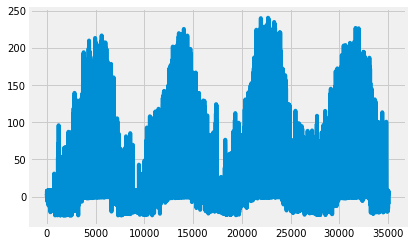

In [68]:
df['net_load_kWh'].plot()

In [69]:
df['net_load_kWh'].describe()

count    35040.000000
mean        31.984345
std         54.630569
min        -25.273320
25%          0.440000
50%          2.350000
75%         46.762478
max        240.619280
Name: net_load_kWh, dtype: float64

In [70]:
df = df.rename(columns={'datetime':'ds',
                        'net_load_kWh':'y'})
# df.head(5)

,ds,daylight_savings,indoor_temp,avg_unmet_cooling_temp,indoor_hum,equipment_electric_power_kWh,dhw_heating_kWh,cooling_load_kWh,solar_generation_W_kW,outdoor_temp,...,pred_12h_diffuse_solar_W_m2,pred_24h_diffuse_solar_W_m2,pred_6h_direct_solar_W_m2,pred_12h_direct_solar_W_m2,pred_24h_direct_solar_W_m2,holiday,workday,solar_generation_kW,y,electric_load_hp_kW
0,2008-01-02 00:00:00,0.0,20.42,0.0,59.00,0.44,0,0.0,0.0,9.40,...,170.84,0.0,-0.00,5.32,0.0,True,False,0.0,0.44,0.0
1,2008-01-02 01:00:00,0.0,20.16,0.0,59.61,0.44,0,0.0,0.0,7.61,...,112.24,0.0,1.11,2.04,-0.0,True,False,0.0,0.44,0.0
2,2008-01-02 02:00:00,0.0,20.00,0.0,59.95,0.44,0,0.0,0.0,8.11,...,65.93,0.0,1.74,1.04,0.0,True,False,0.0,0.44,0.0
3,2008-01-02 03:00:00,0.0,19.78,0.0,60.31,0.44,0,0.0,0.0,8.36,...,38.59,-0.0,1.09,0.99,0.0,True,False,0.0,0.44,0.0
4,2008-01-02 04:00:00,0.0,19.66,0.0,60.29,0.44,0,0.0,0.0,8.78,...,15.92,0.0,1.78,0.84,0.0,True,False,0.0,0.44,0.0


In [71]:
my_model = Prophet(interval_width = 0.95, seasonality_mode="additive")

In [72]:
my_model.fit(df)

Initial log joint probability = -1196.03
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       50096.2   0.000721245       118.322      0.3642      0.3642      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       50100.7    0.00049075       358.496     0.08132           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     293       50101.9   3.91778e-05       115.007   3.018e-07       0.001      411  LS failed, Hessian reset 
     299       50101.9   0.000776224       332.745           1           1      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     348       50102.4   0.000649134       144.713   7.223e-06       0.001      514  LS failed, Hessian reset 
     399       50102.8   0.000578049       67.6663      0.2725           1      575   
    Iter      log pro

In [73]:
future_dates = my_model.make_future_dataframe(periods = 365)
future_dates

,ds
0,2008-01-02 00:00:00
1,2008-01-02 01:00:00
2,2008-01-02 02:00:00
3,2008-01-02 03:00:00
4,2008-01-02 04:00:00
...,...
35400,2012-12-26 23:00:00
35401,2012-12-27 23:00:00
35402,2012-12-28 23:00:00
35403,2012-12-29 23:00:00


In [74]:
forecast = my_model.predict(future_dates)
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-01-02 00:00:00,28.126897,-96.785453,34.494675,28.126897,28.126897,-56.829128,-56.829128,-56.829128,-30.448262,...,1.850491,1.850491,1.850491,-28.231357,-28.231357,-28.231357,0.0,0.0,0.0,-28.702230
1,2008-01-02 01:00:00,28.126935,-97.344923,42.709048,28.126935,28.126935,-57.626322,-57.626322,-57.626322,-31.198275,...,1.815542,1.815542,1.815542,-28.243590,-28.243590,-28.243590,0.0,0.0,0.0,-29.499387
2,2008-01-02 02:00:00,28.126973,-93.602572,41.177904,28.126973,28.126973,-58.000194,-58.000194,-58.000194,-31.536169,...,1.791768,1.791768,1.791768,-28.255793,-28.255793,-28.255793,0.0,0.0,0.0,-29.873221
3,2008-01-02 03:00:00,28.127011,-99.748405,34.915433,28.127011,28.127011,-58.428868,-58.428868,-58.428868,-31.939851,...,1.778950,1.778950,1.778950,-28.267967,-28.267967,-28.267967,0.0,0.0,0.0,-30.301857
4,2008-01-02 04:00:00,28.127048,-98.617364,39.384990,28.127048,28.127048,-58.912012,-58.912012,-58.912012,-32.408620,...,1.776720,1.776720,1.776720,-28.280112,-28.280112,-28.280112,0.0,0.0,0.0,-30.784964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35400,2012-12-26 23:00:00,23.735983,-97.177451,38.452705,10.245053,38.372241,-52.884668,-52.884668,-52.884668,-28.964290,...,2.607200,2.607200,2.607200,-26.527577,-26.527577,-26.527577,0.0,0.0,0.0,-29.148685
35401,2012-12-27 23:00:00,23.720796,-96.430776,37.799487,10.163613,38.419208,-54.322400,-54.322400,-54.322400,-28.964290,...,1.501671,1.501671,1.501671,-26.859781,-26.859781,-26.859781,0.0,0.0,0.0,-30.601604
35402,2012-12-28 23:00:00,23.705608,-101.181581,33.856964,10.082172,38.466175,-56.860968,-56.860968,-56.860968,-28.964290,...,-0.704498,-0.704498,-0.704498,-27.192180,-27.192180,-27.192180,0.0,0.0,0.0,-33.155360
35403,2012-12-29 23:00:00,23.690421,-106.502377,27.636583,10.030035,38.513143,-62.931687,-62.931687,-62.931687,-28.964290,...,-6.447437,-6.447437,-6.447437,-27.519960,-27.519960,-27.519960,0.0,0.0,0.0,-39.241266


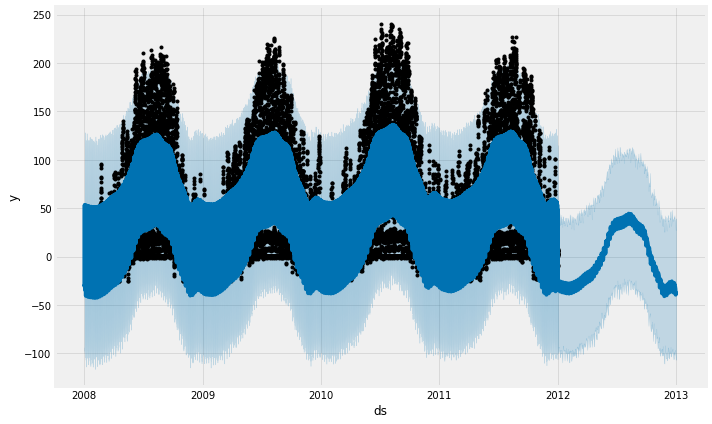

In [75]:
fig = my_model.plot(forecast, uncertainty=True)

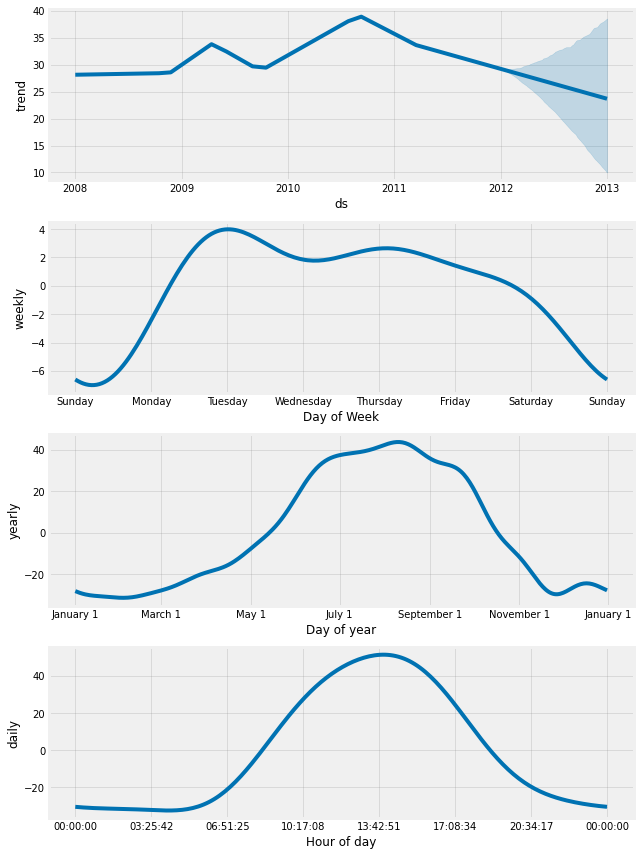

In [76]:
fig = my_model.plot_components(forecast)

In [77]:
# plot_plotly(my_model, forecast)

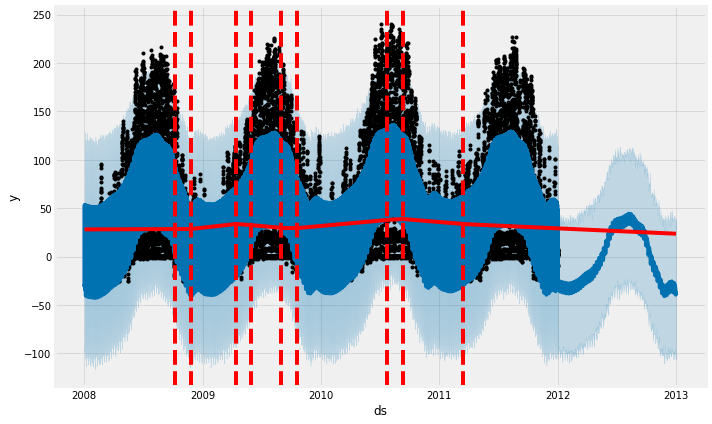

In [78]:
plot1 = my_model.plot(forecast)
a = add_changepoints_to_plot(plot1.gca(),my_model,forecast)

In [79]:
df_cv = cross_validation(my_model, horizon = '180 days', parallel='processes')
df_cv.head()

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x289474610>


Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2009-07-15 00:00:00,41.874252,-23.303049,106.110040,0.44,2009-07-14 23:00:00
1,2009-07-15 01:00:00,41.194566,-21.422740,102.225035,0.44,2009-07-14 23:00:00
2,2009-07-15 02:00:00,40.877811,-21.512373,102.941352,0.44,2009-07-14 23:00:00
3,2009-07-15 03:00:00,40.551830,-19.606336,108.468006,0.44,2009-07-14 23:00:00
4,2009-07-15 04:00:00,40.180976,-25.591420,106.665388,0.44,2009-07-14 23:00:00


In [80]:
df_cv_pm = performance_metrics(df_cv)
df_cv_pm

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days 00:00:00,1277.468256,35.741688,28.711909,19.372913,2.215322,1.227597,0.937757
1,18 days 01:00:00,1277.757473,35.745734,28.715611,19.382423,2.215322,1.227468,0.937757
2,18 days 02:00:00,1278.046577,35.749777,28.718872,19.389835,2.215322,1.227315,0.937757
3,18 days 03:00:00,1278.334980,35.753811,28.721846,19.396595,2.215322,1.227144,0.937757
4,18 days 04:00:00,1278.628510,35.757915,28.724551,19.402743,2.215322,1.226950,0.937757
...,...,...,...,...,...,...,...,...
3884,179 days 20:00:00,1496.507920,38.684725,32.107286,25.016586,2.851150,1.279914,0.931327
3885,179 days 21:00:00,1495.579679,38.672725,32.093149,25.021062,2.855260,1.279704,0.931327
3886,179 days 22:00:00,1495.415474,38.670602,32.086638,25.021964,2.858139,1.279533,0.931327
3887,179 days 23:00:00,1495.248917,38.668449,32.080056,25.019859,2.858139,1.279502,0.931327


<AxesSubplot:xlabel='ds'>

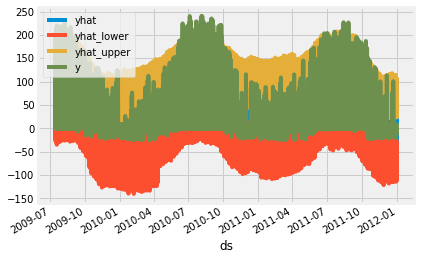

In [81]:
df_cv.drop('cutoff',axis=1).set_index('ds').plot()

### Add holidays

In [83]:
df_holiday = df[['ds','holiday']].query('holiday')
df_holiday['holiday'] = 'Holiday'
df_holiday

,ds,holiday
0,2008-01-02 00:00:00,Holiday
1,2008-01-02 01:00:00,Holiday
2,2008-01-02 02:00:00,Holiday
3,2008-01-02 03:00:00,Holiday
4,2008-01-02 04:00:00,Holiday
...,...,...
34891,2011-12-25 19:00:00,Holiday
34892,2011-12-25 20:00:00,Holiday
34893,2011-12-25 21:00:00,Holiday
34894,2011-12-25 22:00:00,Holiday


In [84]:
df_workday = df[['ds','workday']].query('workday')
df_workday['holiday'] = 'Workday'
df_workday = df_workday.drop('workday', axis=1)

In [85]:
df_holidays = pd.concat([df_holiday, df_workday], ignore_index=True)

In [86]:
df_holidays

,ds,holiday
0,2008-01-02 00:00:00,Holiday
1,2008-01-02 01:00:00,Holiday
2,2008-01-02 02:00:00,Holiday
3,2008-01-02 03:00:00,Holiday
4,2008-01-02 04:00:00,Holiday
...,...,...
25315,2011-12-31 19:00:00,Workday
25316,2011-12-31 20:00:00,Workday
25317,2011-12-31 21:00:00,Workday
25318,2011-12-31 22:00:00,Workday


In [87]:
my_model = Prophet(interval_width = 0.95, seasonality_mode='additive',
                    holidays=df_holidays)
my_model.fit(df)

Initial log joint probability = -1196.03
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       50126.2    0.00873393       240.577           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       50131.1    0.00110907       130.771           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         50133    0.00255904       167.633           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334       50133.5   6.12809e-05       150.945   1.987e-07       0.001      426  LS failed, Hessian reset 
     399         50134   0.000128252       110.921           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     421       50134.5   0.000243327    

In [88]:
forecast = my_model.predict(future_dates)

In [89]:
forecast[(forecast['Holiday']+ forecast['Workday']).abs()>0][
    ['ds','Holiday','Workday']][-10:]

,ds,Holiday,Workday
35030,2011-12-31 14:00:00,0.0,-7.156921
35031,2011-12-31 15:00:00,0.0,-7.156921
35032,2011-12-31 16:00:00,0.0,-7.156921
35033,2011-12-31 17:00:00,0.0,-7.156921
35034,2011-12-31 18:00:00,0.0,-7.156921
35035,2011-12-31 19:00:00,0.0,-7.156921
35036,2011-12-31 20:00:00,0.0,-7.156921
35037,2011-12-31 21:00:00,0.0,-7.156921
35038,2011-12-31 22:00:00,0.0,-7.156921
35039,2011-12-31 23:00:00,0.0,-7.156921


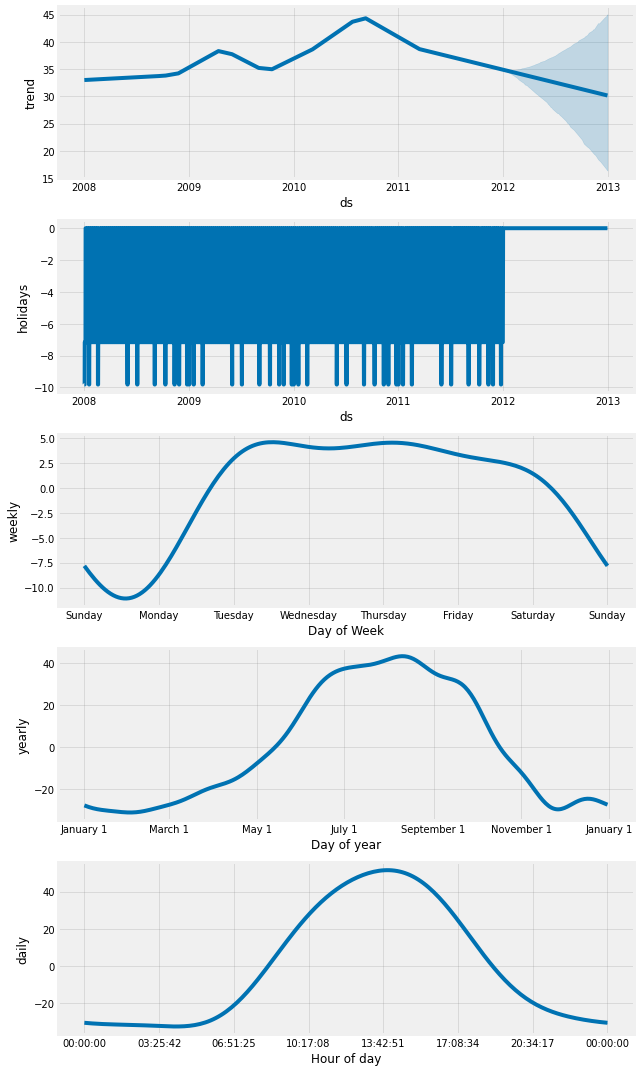

In [90]:
fig = my_model.plot_components(forecast)

In [91]:
df_cv = cross_validation(my_model, horizon = '180 days', parallel='processes')

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x28d0d4520>


Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       18500.3    0.00146396       102.609      0.5083      0.5083      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint proba

In [92]:
df_cv_pm = performance_metrics(df_cv)

In [93]:
df_cv_pm

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days 00:00:00,1273.342620,35.683927,28.668151,19.513782,2.213276,1.225678,0.939043
1,18 days 01:00:00,1273.772231,35.689946,28.671846,19.523171,2.213276,1.225515,0.939043
2,18 days 02:00:00,1274.186542,35.695750,28.675121,19.530615,2.213276,1.225324,0.939043
3,18 days 03:00:00,1274.586666,35.701354,28.678126,19.537443,2.213276,1.225113,0.939043
4,18 days 04:00:00,1274.978751,35.706845,28.680873,19.543687,2.213276,1.224877,0.939043
...,...,...,...,...,...,...,...,...
3884,179 days 20:00:00,1483.515525,38.516432,31.850893,24.400918,2.884151,1.283455,0.931842
3885,179 days 21:00:00,1482.517217,38.503470,31.836238,24.405478,2.887546,1.283332,0.931842
3886,179 days 22:00:00,1482.292913,38.500557,31.828137,24.406216,2.891151,1.282921,0.931842
3887,179 days 23:00:00,1482.084301,38.497848,31.819788,24.403922,2.891151,1.282741,0.931842


### Fourier Order for Seasonalities

In [94]:
my_model = Prophet(interval_width = 0.95, seasonality_mode='additive',
                    holidays=df_holidays, yearly_seasonality=3)
my_model.fit(df)

Initial log joint probability = -1196.03
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         50024    0.00202903       172.055           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       50028.1   0.000824943       83.3036      0.8522      0.8522      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       50028.8   6.88038e-05       115.234   1.724e-07       0.001      328  LS failed, Hessian reset 
     299       50029.7   0.000874584       171.431           1           1      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         50031   0.000737226       140.196      0.8053      0.8053      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     425       50031.2   0.000522423    

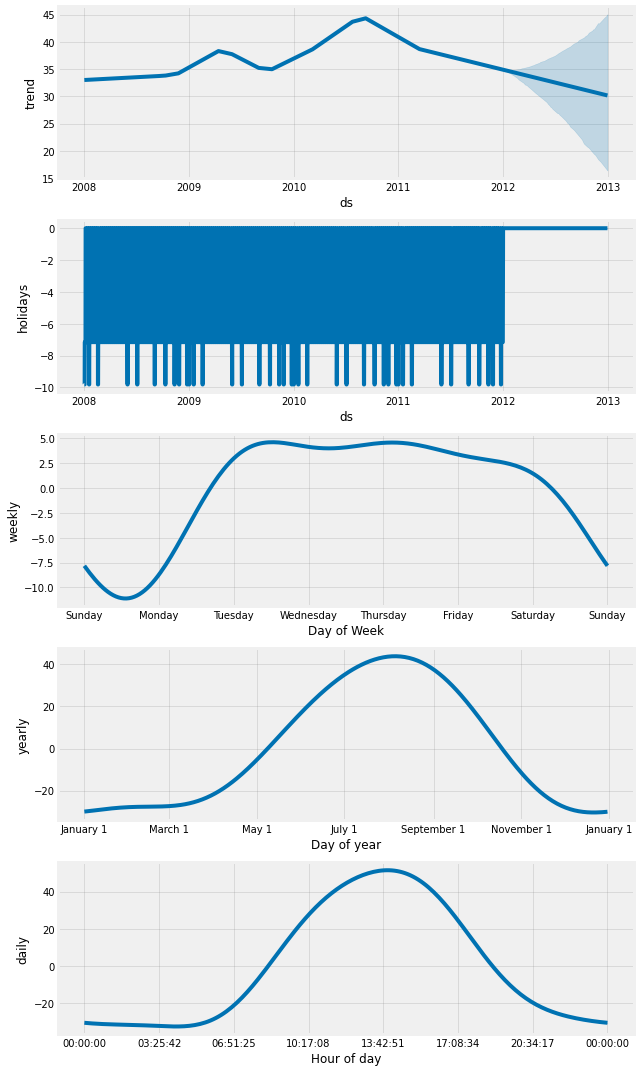

In [95]:
fig = my_model.plot_components(forecast)

In [96]:
df_cv = cross_validation(my_model, horizon = '180 days', parallel='processes')
df_cv_pm = performance_metrics(df_cv)
df_cv_pm

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17f265370>


Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       18440.7   0.000808827       143.971      0.9662      0.

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days 00:00:00,1269.670078,35.632430,28.378390,19.594847,2.286884,1.210424,0.944444
1,18 days 01:00:00,1270.024737,35.637406,28.380075,19.601089,2.286062,1.210320,0.944444
2,18 days 02:00:00,1270.356530,35.642061,28.381331,19.603941,2.286062,1.210205,0.944444
3,18 days 03:00:00,1270.667696,35.646426,28.382304,19.606154,2.286062,1.210083,0.944444
4,18 days 04:00:00,1270.963724,35.650578,28.383009,19.607756,2.286062,1.209952,0.944444
...,...,...,...,...,...,...,...,...
3884,179 days 20:00:00,1478.521588,38.451549,31.830071,24.778626,2.869854,1.286551,0.934156
3885,179 days 21:00:00,1477.902145,38.443493,31.820989,24.782963,2.886081,1.286199,0.934156
3886,179 days 22:00:00,1477.893026,38.443374,31.817394,24.783138,2.888351,1.285849,0.934156
3887,179 days 23:00:00,1477.858336,38.442923,31.812564,24.780111,2.888351,1.285532,0.934156


### Assume different weekly sesonalities. Summer vs Winter

In [97]:
def is_winter_season(ds):
    date = pd.to_datetime(ds)
    return(date.month < 4 or date.month > 9)

df['winter'] = df['ds'].apply(is_winter_season)
df['summer'] = ~df['ds'].apply(is_winter_season)

In [98]:
my_model = Prophet(interval_width = 0.95, seasonality_mode='additive',
                    holidays=df_holidays, weekly_seasonality=False)
my_model.add_seasonality(name='weekly_on_winter', period = 7, fourier_order=10, condition_name='winter')
my_model.add_seasonality(name='weekly_on_summer', period = 7, fourier_order=10, condition_name='summer')
my_model.fit(df)

Initial log joint probability = -1196.03


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       58287.1   9.02241e-05       186.852      0.1963      0.1963      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       58297.8   0.000767242       412.541           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       58301.8   0.000897217       152.741           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     335       58302.4   9.97041e-05       288.503   4.249e-07       0.001      457  LS failed, Hessian reset 
     399       58302.8   7.16797e-05       79.6341           1           1      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       58303.9    0.00148344       151.558           1           1      6

In [99]:
future_dates['winter'] = future_dates['ds'].apply(is_winter_season)
future_dates['summer'] = ~future_dates['ds'].apply(is_winter_season)
forecast = my_model.predict(future_dates)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Holiday,Holiday_lower,Holiday_upper,Workday,...,weekly_on_winter,weekly_on_winter_lower,weekly_on_winter_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-01-02 00:00:00,24.715299,-62.999562,44.372310,24.715299,24.715299,-0.099794,-0.099794,-0.099794,0.0,...,13.880695,13.880695,13.880695,-27.490323,-27.490323,-27.490323,0.0,0.0,0.0,-6.579422
1,2008-01-02 01:00:00,24.715134,-63.180043,47.811868,24.715134,24.715134,-0.099794,-0.099794,-0.099794,0.0,...,13.529279,13.529279,13.529279,-27.503589,-27.503589,-27.503589,0.0,0.0,0.0,-6.531671
2,2008-01-02 02:00:00,24.714970,-63.822721,45.415126,24.714970,24.714970,-0.099794,-0.099794,-0.099794,0.0,...,12.307719,12.307719,12.307719,-27.516837,-27.516837,-27.516837,0.0,0.0,0.0,-7.898193
3,2008-01-02 03:00:00,24.714806,-68.005896,42.528256,24.714806,24.714806,-0.099794,-0.099794,-0.099794,0.0,...,10.288495,10.288495,10.288495,-27.530069,-27.530069,-27.530069,0.0,0.0,0.0,-11.098705
4,2008-01-02 04:00:00,24.714642,-68.160983,36.026082,24.714642,24.714642,-0.099794,-0.099794,-0.099794,0.0,...,7.597762,7.597762,7.597762,-27.543283,-27.543283,-27.543283,0.0,0.0,0.0,-15.954012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35400,2012-12-26 23:00:00,18.430726,-72.577694,42.549934,-0.135078,39.094367,0.000000,0.000000,0.000000,0.0,...,13.553950,13.553950,13.553950,-25.756449,-25.756449,-25.756449,0.0,0.0,0.0,-11.912111
35401,2012-12-27 23:00:00,18.413657,-63.526929,53.207523,-0.225376,39.163045,0.000000,0.000000,0.000000,0.0,...,14.516720,14.516720,14.516720,-26.079336,-26.079336,-26.079336,0.0,0.0,0.0,-11.289296
35402,2012-12-28 23:00:00,18.396588,-69.103961,46.326399,-0.315673,39.235200,0.000000,0.000000,0.000000,0.0,...,13.081630,13.081630,13.081630,-26.409145,-26.409145,-26.409145,0.0,0.0,0.0,-13.071264
35403,2012-12-29 23:00:00,18.379519,-69.473294,45.981738,-0.433425,39.307355,0.000000,0.000000,0.000000,0.0,...,13.581942,13.581942,13.581942,-26.741387,-26.741387,-26.741387,0.0,0.0,0.0,-12.920263


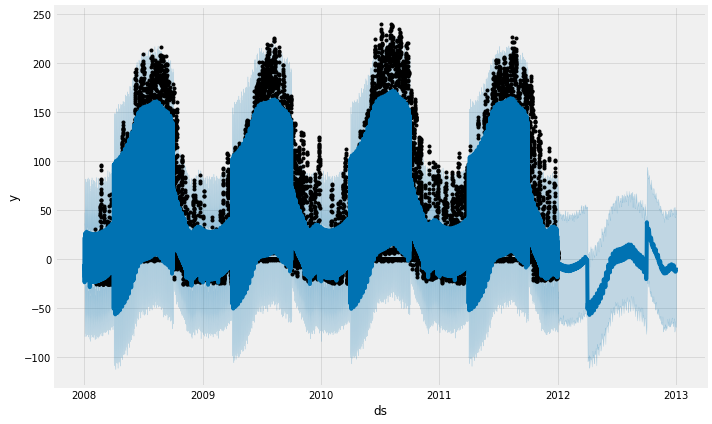

In [100]:
fig = my_model.plot(forecast, uncertainty=True)

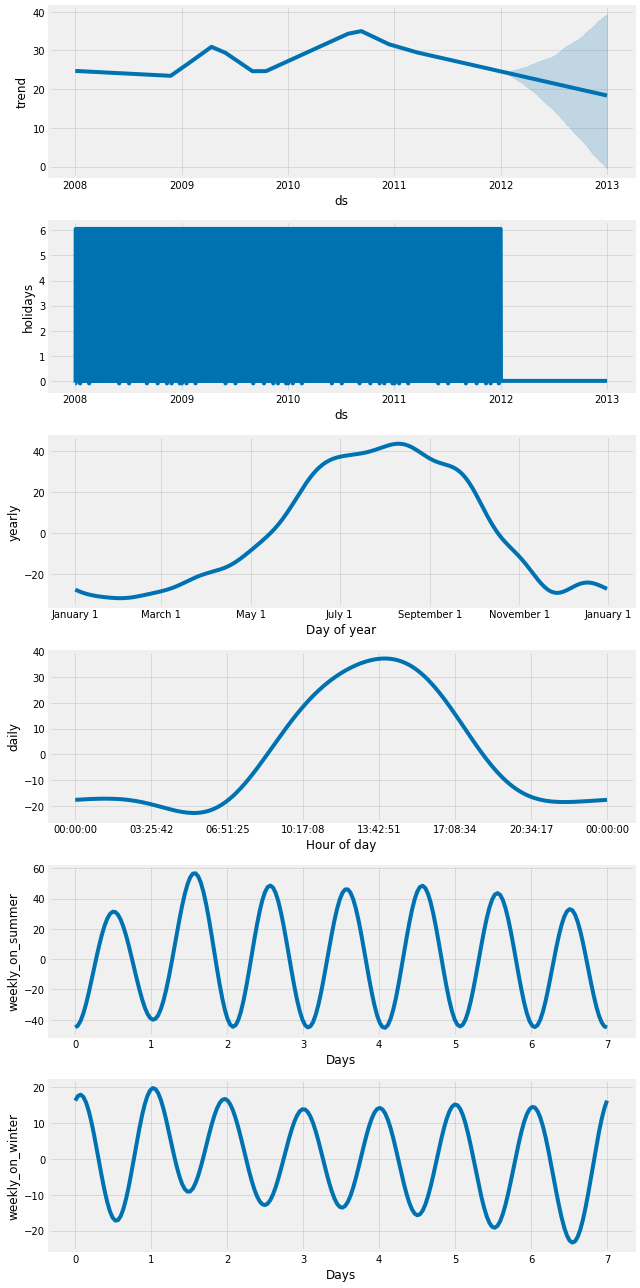

In [101]:
fig = my_model.plot_components(forecast)

In [102]:
df_cv = cross_validation(my_model, horizon = '180 days', parallel='processes')
df_cv_pm = performance_metrics(df_cv)
df_cv_pm

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x28aca2760>


Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob       

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days 00:00:00,1060.823798,32.570290,25.178865,16.700848,1.619378,1.188703,0.897119
1,18 days 01:00:00,1060.028438,32.558078,25.163049,16.664491,1.619378,1.188592,0.897377
2,18 days 02:00:00,1059.234335,32.545880,25.148423,16.631251,1.613560,1.188044,0.897634
3,18 days 03:00:00,1058.516349,32.534848,25.135919,16.602832,1.610006,1.187848,0.897634
4,18 days 04:00:00,1057.966625,32.526399,25.127991,16.584813,1.610006,1.187841,0.897634
...,...,...,...,...,...,...,...,...
3884,179 days 20:00:00,1085.417887,32.945681,25.604653,18.915364,2.386930,1.263324,0.894547
3885,179 days 21:00:00,1085.318771,32.944177,25.603474,18.918134,2.364032,1.263313,0.894290
3886,179 days 22:00:00,1086.463404,32.961544,25.614690,18.918867,2.375123,1.263447,0.894033
3887,179 days 23:00:00,1088.194549,32.987794,25.633844,18.920761,2.394875,1.263575,0.893776


/Users/erick/neuefische/GreenCitySolutions/TheGreenCitySolutionsGroup/.venv/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/Users/erick/neuefische/GreenCitySolutions/TheGreenCitySolutionsGroup/.venv/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


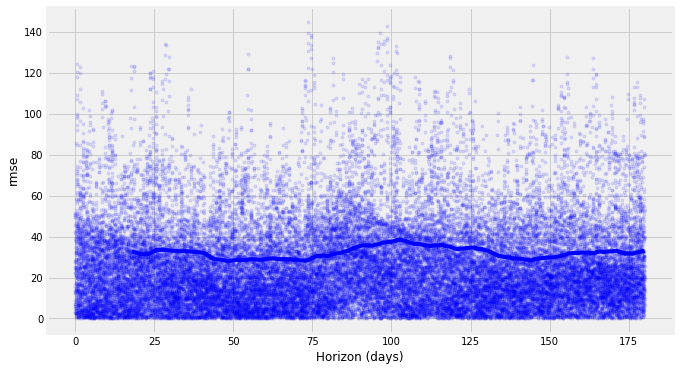

In [103]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

### Review Holidays as only holidays, do not count for working days

Initial log joint probability = -1196.03
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       58274.9    0.00194115       304.772           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       58284.6    0.00501667       315.954           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       58289.6    0.00113761       207.025       4.127      0.4127      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       58291.4    0.00572461       260.137           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     401       58291.4   9.26852e-05       255.088   4.824e-07       0.001      516  LS failed, Hessian reset 
     457       58291.8   2.72673e-05    

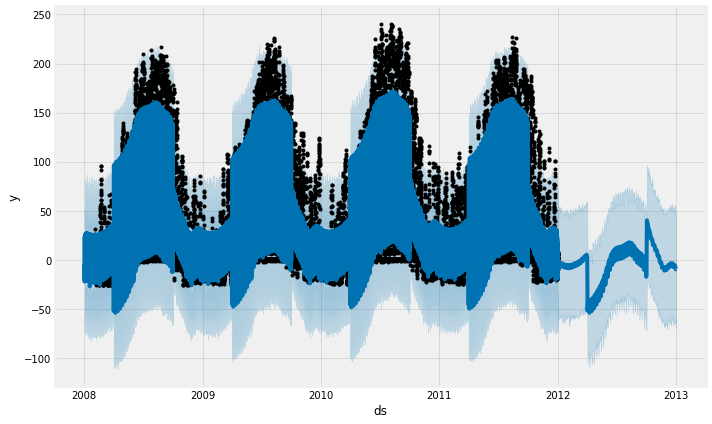

In [104]:
df_holidays = df_holiday
my_model = Prophet(interval_width = 0.95, seasonality_mode='additive',
                    holidays=df_holidays, weekly_seasonality=False)
my_model.add_seasonality(name='weekly_on_winter', period = 7, fourier_order=10, condition_name='winter')
my_model.add_seasonality(name='weekly_on_summer', period = 7, fourier_order=10, condition_name='summer')
my_model.fit(df)
forecast = my_model.predict(future_dates)
fig = my_model.plot(forecast, uncertainty=True)

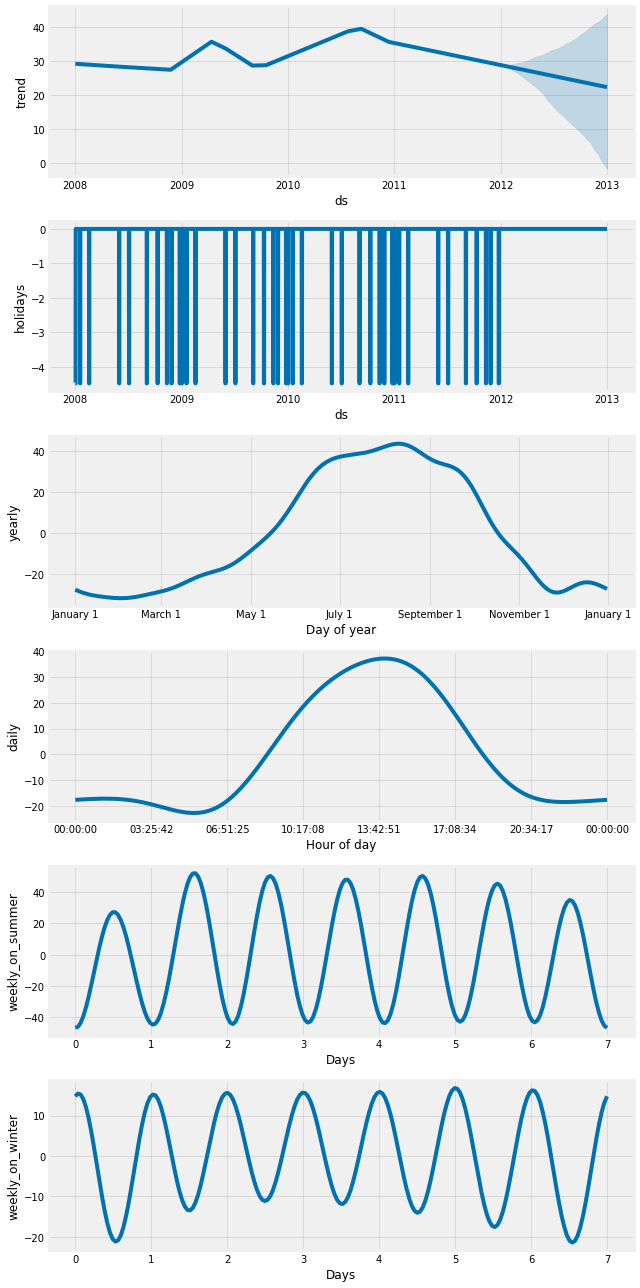

In [105]:
fig = my_model.plot_components(forecast)

In [106]:
df_cv = cross_validation(my_model, horizon = '180 days', parallel='processes')
df_cv_pm = performance_metrics(df_cv)
df_cv_pm

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17f9389d0>


Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days 00:00:00,1060.804890,32.570000,25.195479,16.722910,1.632555,1.187990,0.898663
1,18 days 01:00:00,1060.061112,32.558580,25.181821,16.691196,1.632555,1.187976,0.898663
2,18 days 02:00:00,1059.307340,32.547002,25.168842,16.661698,1.631060,1.187589,0.898663
3,18 days 03:00:00,1058.620470,32.536448,25.157465,16.635841,1.631060,1.187517,0.898663
4,18 days 04:00:00,1058.091171,32.528313,25.149859,16.618554,1.631060,1.187532,0.898663
...,...,...,...,...,...,...,...,...
3884,179 days 20:00:00,1078.331422,32.837957,25.568686,18.867790,2.376846,1.264662,0.897377
3885,179 days 21:00:00,1078.158896,32.835330,25.566880,18.870629,2.348486,1.264646,0.897119
3886,179 days 22:00:00,1079.285351,32.852479,25.577356,18.871551,2.361107,1.264743,0.896862
3887,179 days 23:00:00,1081.049948,32.879324,25.596255,18.873874,2.384172,1.264813,0.896605


/Users/erick/neuefische/GreenCitySolutions/TheGreenCitySolutionsGroup/.venv/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/Users/erick/neuefische/GreenCitySolutions/TheGreenCitySolutionsGroup/.venv/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


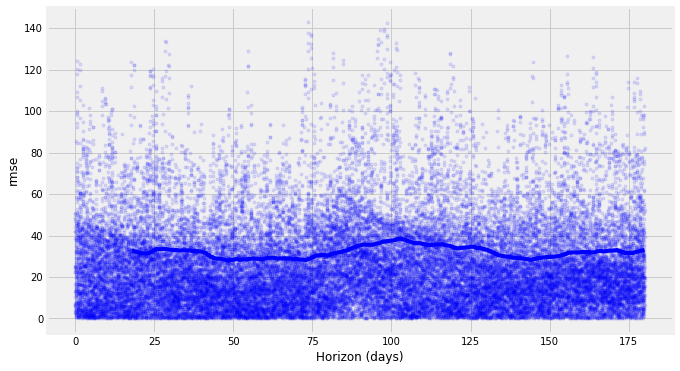

In [107]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

### Hyperparameter tunning

In [108]:
param_grid = {
    'changepoint_prior_scale':[0.0001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale':[0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] # Store the RMSEs for each params her

# Use cross valiation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, 
                interval_width = 0.95, 
                seasonality_mode='additive',
                holidays=df_holidays, 
                weekly_seasonality=False)
    m.add_seasonality(name='weekly_on_winter', period = 7, fourier_order=10, condition_name='winter')
    m.add_seasonality(name='weekly_on_summer', period = 7, fourier_order=10, condition_name='summer')
    m.fit(df)
    df_cv = cross_validation(m, horizon='180 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

#Find the best parameter
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

Initial log joint probability = -1196.03
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       57657.2   3.19582e-05       53437.3   7.704e-10       0.001      132  LS failed, Hessian reset 
      99       57658.8   2.28294e-07       48010.5           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       57664.2   4.35189e-09       47761.4       0.368       0.368      253   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x28adb80d0>


Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17f261dc0>


Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17ff8f5e0>


Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x28adb80d0>


Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x28adb8370>


Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17f732c10>


Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17f261c40>


Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17f261d90>


Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x28adb80d0>


Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17ed82d30>


Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17ed80b20>


Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17f261850>


Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17f941a00>


Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17f261f70>


Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17f261430>


Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob       

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17f261d90>


Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -928.52
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
    Iter      log prob       

In [109]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.0001, 'seasonality_prior_scale': 0.01}


### Train best model

Initial log joint probability = -1196.03
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       57657.2   3.19582e-05       53437.3   7.704e-10       0.001      132  LS failed, Hessian reset 
      99       57658.8   2.28294e-07       48010.5           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       57664.2   4.35189e-09       47761.4       0.368       0.368      253   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


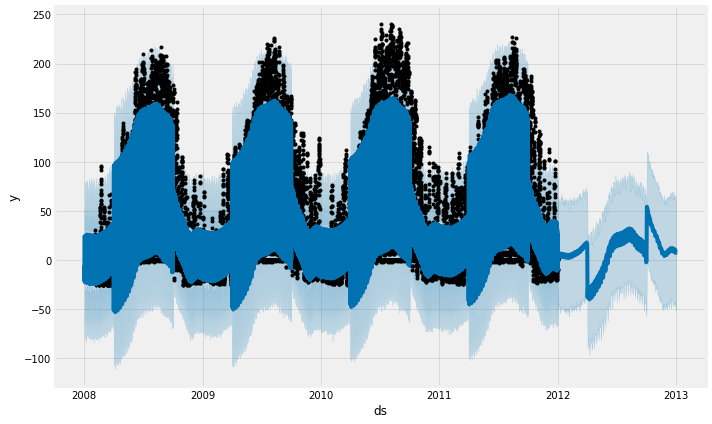

In [110]:
df_holidays = df_holiday
my_model = Prophet(interval_width = 0.95, seasonality_mode='additive',
                    holidays=df_holidays, weekly_seasonality=False,
                    **best_params)
my_model.add_seasonality(name='weekly_on_winter', period = 7, fourier_order=10, condition_name='winter')
my_model.add_seasonality(name='weekly_on_summer', period = 7, fourier_order=10, condition_name='summer')
my_model.fit(df)
forecast = my_model.predict(future_dates)
fig = my_model.plot(forecast, uncertainty=True)

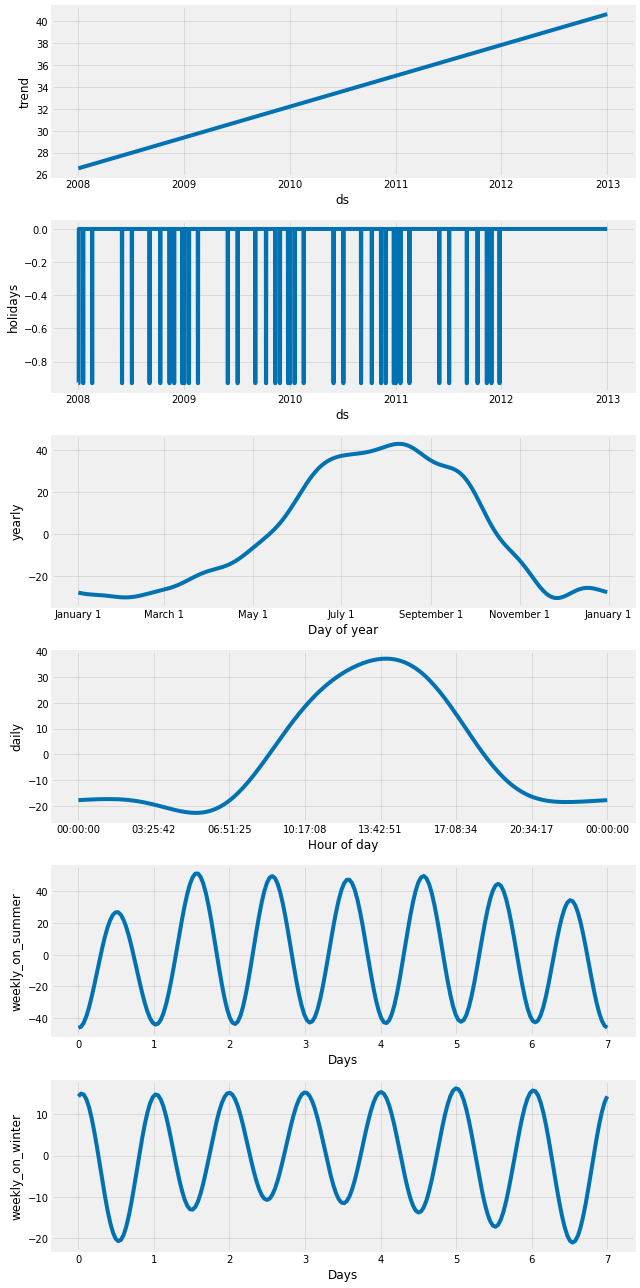

In [111]:
fig = my_model.plot_components(forecast)

In [112]:
df_cv = cross_validation(my_model, horizon = '180 days', parallel='processes')
df_cv_pm = performance_metrics(df_cv)
df_cv_pm

INFO:prophet:Making 9 forecasts with cutoffs between 2009-07-14 23:00:00 and 2011-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17faa1a30>


Initial log joint probability = -470.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -623.763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -608.256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -595.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -632.701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -908.413
Initial log joint probability = -928.52
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -887.924
    Iter      log prob       

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days 00:00:00,1028.159246,32.064922,25.399862,18.060848,1.851375,1.157985,0.916667
1,18 days 01:00:00,1027.427984,32.053517,25.388638,18.036236,1.851375,1.157952,0.916667
2,18 days 02:00:00,1026.701617,32.042185,25.378526,18.013254,1.851375,1.157932,0.916667
3,18 days 03:00:00,1026.047057,32.031969,25.369455,17.992638,1.851375,1.157910,0.916667
4,18 days 04:00:00,1025.538711,32.024033,25.361235,17.973955,1.851375,1.157847,0.916667
...,...,...,...,...,...,...,...,...
3884,179 days 20:00:00,980.092342,31.306427,24.099022,13.783490,2.236220,1.176434,0.916667
3885,179 days 21:00:00,979.622565,31.298923,24.091065,13.783228,2.230950,1.176706,0.916667
3886,179 days 22:00:00,979.802905,31.301804,24.096228,13.782775,2.229175,1.177085,0.916667
3887,179 days 23:00:00,980.391038,31.311197,24.109412,13.784023,2.232703,1.177529,0.916667
